# LIGO - Gravitational Waves Detectability

**Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't.**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append(r"C:\Users\Phisio97\Documents\Astrostatistics\Notebooks")
sys.path.append(r"C:\Users\Phisio97\Documents\Astrostatistics\Notebooks")
from Utilities import plot_settings

Load downsampled data with balanced classes members

In [7]:
y = np.load(r"C:\Users\Phisio97\Documents\Astrostatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\y.npy")

In [10]:
data = np.load(r"C:\Users\Phisio97\Documents\Astrostatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\data.npy")

In [11]:
keys = np.load(r"C:\Users\Phisio97\Documents\Astrostatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\keys.npy")

In [12]:
df = pd.DataFrame(data, columns=keys)

In [13]:
df = df.drop(columns=['snr', 'det'])

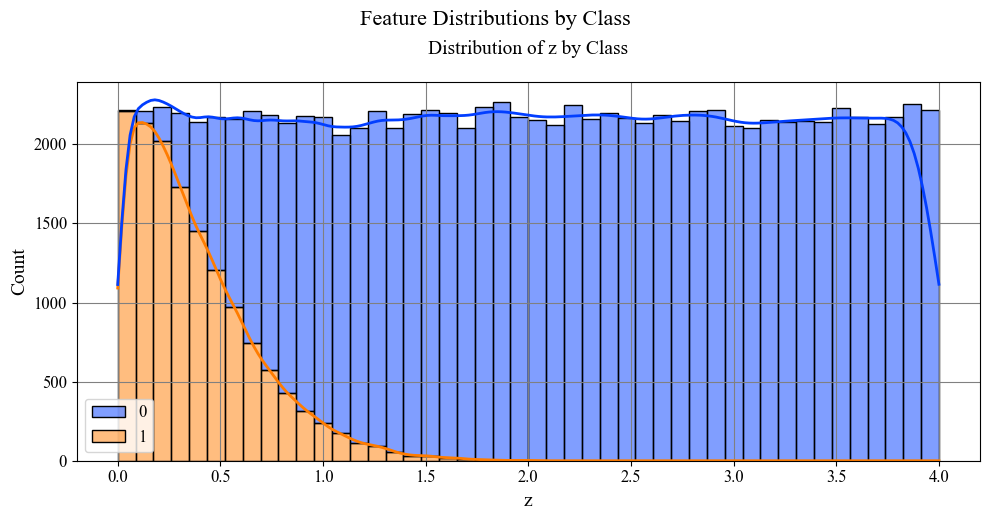

In [14]:
col = 12
sns.histplot(data=df, x=df.columns[col], hue=y, multiple='stack', bins='scott', kde=True, palette='bright')
plt.title(f'Distribution of {df.columns[col]} by Class', fontsize=14)
plt.xlabel(df.columns[col])
plt.ylabel('Count')

plt.tight_layout()
plt.suptitle('Feature Distributions by Class', fontsize=16, y=1.03);

None of the features seems to exhibit an apparent classification boundary.\
Let's try to see what PCA tells me about explained variance ratio.

In [15]:
X = df.to_numpy()

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [17]:
Scaler = RobustScaler()
X_scaled = Scaler.fit_transform(X)

In [18]:
pca = PCA(n_components=int(X.shape[1]))
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'Explained variance ratio')

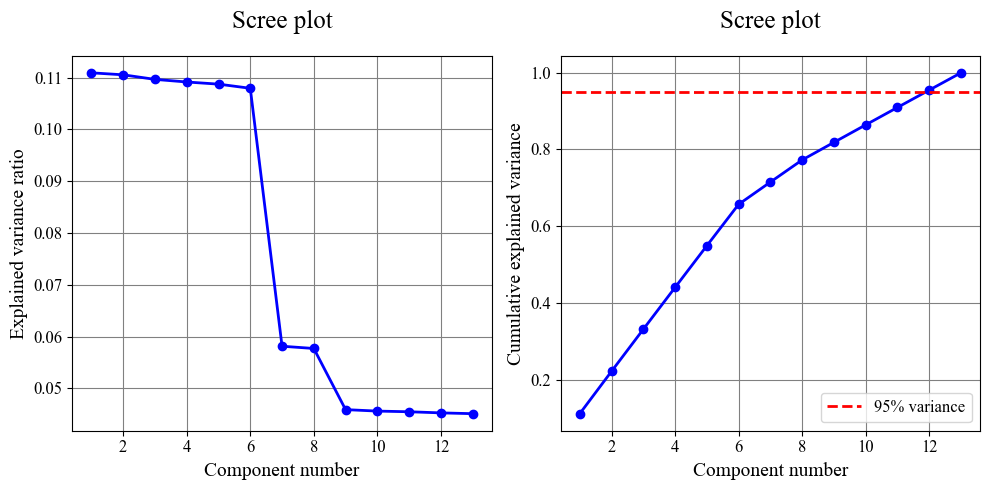

In [19]:
fig, axs = plt.subplots(1, 2)
axs[1].plot(range(1,pca.n_components+1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='blue')
axs[1].set_title('Scree plot')
axs[1].set_xlabel('Component number')
axs[1].axhline(0.95, 0, 1, linestyle='--', color='red', label='95% variance')
axs[1].set_ylabel('Cumulative explained variance')
axs[1].legend()

axs[0].plot(range(1,pca.n_components+1), pca.explained_variance_ratio_, marker='o', linestyle='-', color='blue')
axs[0].set_title('Scree plot')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Explained variance ratio')

Looking at the scree plot, to explain $95 \%$ of the variance I'd need at least 12 over 13 features...not encouraging.\
Maybe the relationships between features are non linear. Let's see what LLE has to say about this.

In [27]:
X_ds = X[::10, :]
y_ds = y[::10]

In [34]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE

In [43]:
LLE = LocallyLinearEmbedding(n_components=3, n_neighbors=20)
X_lle = LLE.fit_transform(X_ds)

In [44]:
tsne = TSNE(n_components=3,
            perplexity=30,
            learning_rate=200,
            random_state=42)
X_tsne = tsne.fit_transform(X_ds)

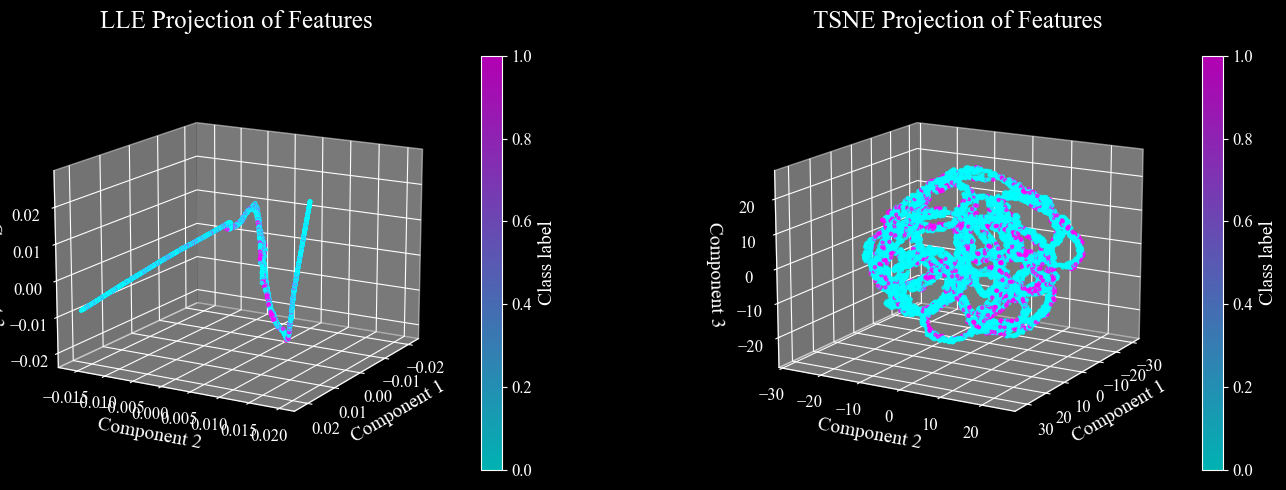

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

with plt.style.context('dark_background'):

    fig = plt.figure(figsize=(15, 5))

    # --- LLE 3D ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    p1 = ax1.scatter(X_lle[:, 0], X_lle[:, 1], X_lle[:, 2], c=y_ds, cmap='cool', s=5, alpha=0.7)
    fig.colorbar(p1, ax=ax1, label='Class label')
    ax1.set_title("LLE Projection of Features")
    ax1.set_xlabel("Component 1")
    ax1.set_ylabel("Component 2")
    ax1.set_zlabel("Component 3")

    # --- t-SNE 3D ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    p2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_ds, cmap='cool', s=5, alpha=0.7)
    fig.colorbar(p2, ax=ax2, label='Class label')
    ax2.set_title("TSNE Projection of Features")
    ax2.set_xlabel("Component 1")
    ax2.set_ylabel("Component 2")
    ax2.set_zlabel("Component 3")
    ax2.view_init(elev=15, azim=30)
    ax1.view_init(elev=15, azim=30)

    plt.tight_layout()
    plt.show()

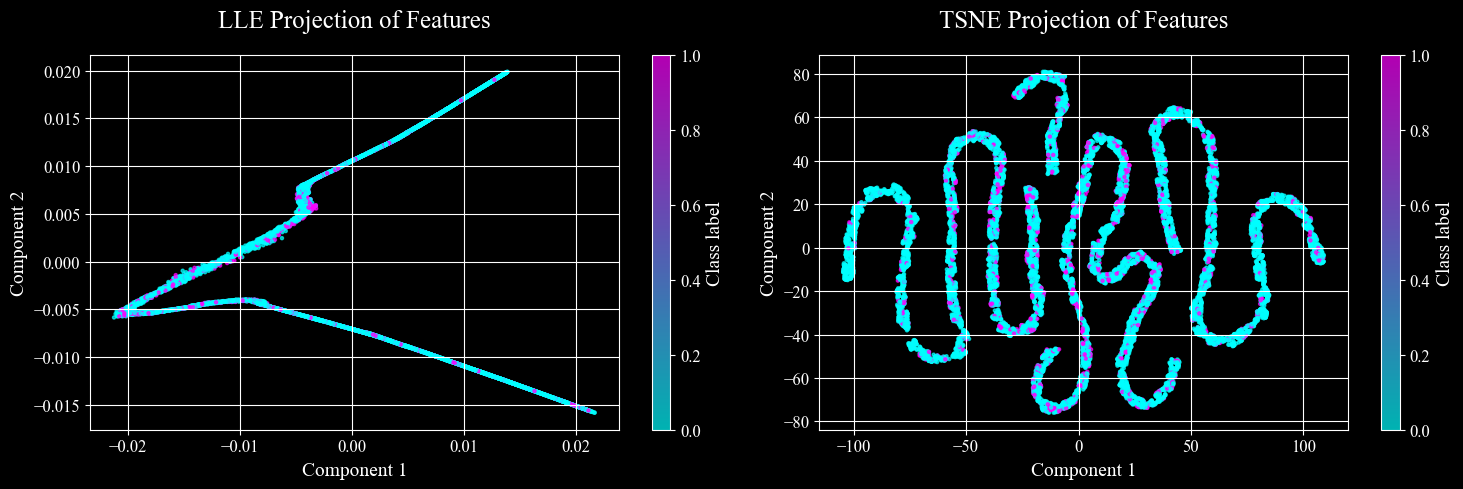

In [42]:
with plt.style.context('dark_background'):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_lle[:, 0], X_lle[:, 1], c=y_ds, cmap='cool', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Class label')
    plt.title("LLE Projection of Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_ds, cmap='cool', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Class label')
    plt.title("TSNE Projection of Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()

I used a downsampled version of my original dataset. It's clear then neitheer of the models are doing well on this task. I'll surrender and use all of the features. But wait... I could use a classification algorithm which selects itself the best sub-set of features that best discriminate the classes, given the data: Random Forest with Boosting!

## Classification : Random Forest Boosting

In [86]:
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42, shuffle=True)
X_test, X_cv, y_test, y_cv = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [88]:
classifier = HGBC(loss='log_loss',
                 learning_rate=0.1,
                 max_leaf_nodes=31,
                 class_weight='balanced',
                 verbose=2)

Binning 0.004 GB of training data: 

0.059 s
Binning 0.000 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 15 leaves, max depth = 5, train loss: 0.68515, val loss: 0.68530, in 0.009s
[2/100] 1 tree, 15 leaves, max depth = 5, train loss: 0.67732, val loss: 0.67761, in 0.011s
[3/100] 1 tree, 15 leaves, max depth = 5, train loss: 0.66963, val loss: 0.67005, in 0.013s
[4/100] 1 tree, 15 leaves, max depth = 6, train loss: 0.66210, val loss: 0.66267, in 0.013s
[5/100] 1 tree, 15 leaves, max depth = 5, train loss: 0.65471, val loss: 0.65539, in 0.010s
[6/100] 1 tree, 15 leaves, max depth = 7, train loss: 0.64742, val loss: 0.64825, in 0.012s
[7/100] 1 tree, 15 leaves, max depth = 6, train loss: 0.64029, val loss: 0.64126, in 0.011s
[8/100] 1 tree, 15 leaves, max depth = 7, train loss: 0.63325, val loss: 0.63434, in 0.004s
[9/100] 1 tree, 15 leaves, max depth = 6, train loss: 0.62638, val loss: 0.62758, in 0.017s
[10/100] 1 tree, 15 leaves, max depth = 6, train loss: 0.61963, val loss: 0.62093, in 

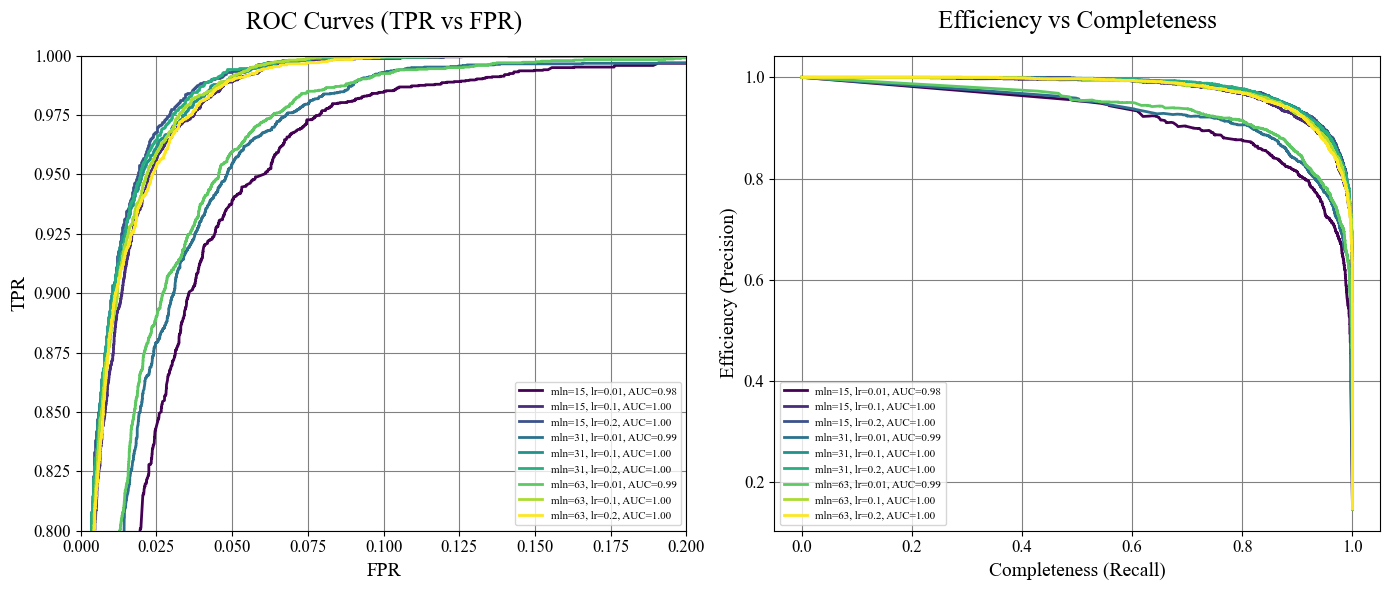

In [96]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.base import clone

# Get all param combinations
param_grid = {
    'max_leaf_nodes': [15, 31, 63],     
    'learning_rate': [0.01, 0.1, 0.2]
}

from itertools import product
param_combinations = list(product(param_grid['max_leaf_nodes'], param_grid['learning_rate']))

# Prepare figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(param_combinations)))

best_auc = 0
best_model = None
best_params = None

for (max_leaf_nodes, learning_rate), color in zip(param_combinations, colors):
    # Clone and set parameters
    model = clone(classifier)
    model.set_params(max_leaf_nodes=max_leaf_nodes, learning_rate=learning_rate)

    # Fit on entire training data
    model.fit(X_train, y_train)

    # Predict probabilities
    y_probs = model.predict_proba(X_cv)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_cv, y_probs)
    roc_auc = auc(fpr, tpr)
    label = f'mln={max_leaf_nodes}, lr={learning_rate}, AUC={roc_auc:.2f}'
    axs[0].plot(fpr, tpr, label=label, color=color)

    # Efficiency vs Completeness
    precision, recall, _ = precision_recall_curve(y_cv, y_probs)
    axs[1].plot(recall, precision, label=label, color=color)
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = model
        best_params = {'max_leaf_nodes': max_leaf_nodes, 'learning_rate': learning_rate}

print(f"Best params: {best_params}")
print(f"Best AUC on CV set: {best_auc:.4f}")

# ROC Plot
axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0].set_title("ROC Curves (TPR vs FPR)")
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].legend(fontsize=8)
axs[0].grid(True)
axs[0].set_xlim(0, 0.2)
axs[0].set_ylim(0.8, 1)

axs[1].set_title("Efficiency vs Completeness")
axs[1].set_xlabel("Completeness (Recall)")
axs[1].set_ylabel("Efficiency (Precision)")
axs[1].legend(fontsize=8)
axs[1].grid(True)
plt.tight_layout()
plt.show()


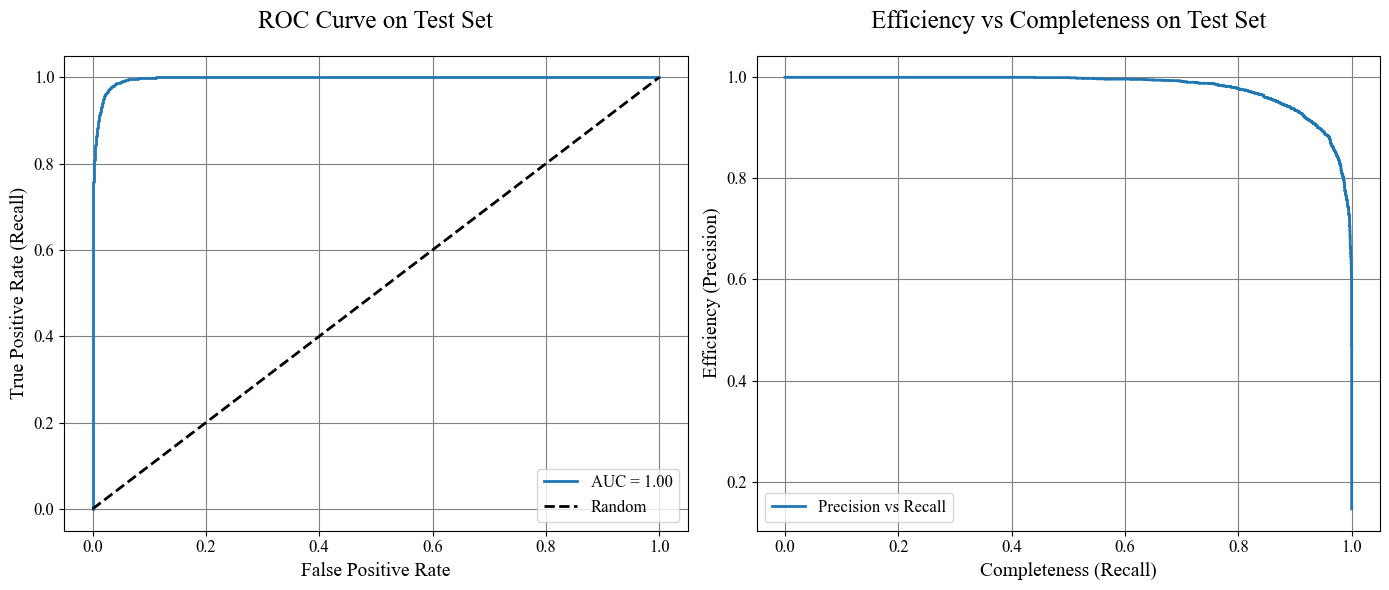

In [97]:
y_probs = best_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- ROC curve: TPR vs FPR ---
axs[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
axs[0].plot([0, 1], [0, 1], 'k--', label='Random')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate (Recall)')
axs[0].set_title('ROC Curve on Test Set')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# --- Efficiency vs Completeness (Precision vs Recall) ---
axs[1].plot(recall, precision, label='Precision vs Recall')
axs[1].set_xlabel('Completeness (Recall)')
axs[1].set_ylabel('Efficiency (Precision)')
axs[1].set_title('Efficiency vs Completeness on Test Set')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()